In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dir_path = 'D:/competition/kaggle/riiid-test-answer-prediction/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

nrows = 100 * 10000
# nrows = None
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int16',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        })
# 没有读入user_answer[-1,0,1,2,3]

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )

# Train

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int16  
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 36.2+ MB


In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [8]:
train.tail()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
999995,999995,26482248,20949024,8803,0,29,1,14000.0,True
999996,999996,26516686,20949024,4664,0,30,1,17000.0,True
999997,999997,26537967,20949024,4108,0,31,0,18000.0,True
999998,999998,26590240,20949024,5014,0,32,0,6000.0,True
999999,999999,26605316,20949024,9828,0,33,0,46000.0,True


Text(0.5, 1.0, 'label dis')

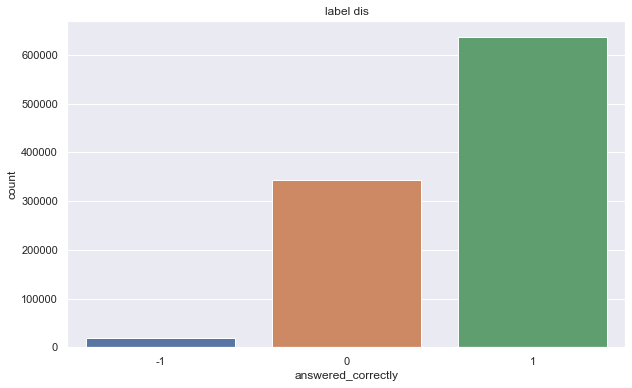

In [11]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='answered_correctly')
plt.title('label dis')

Text(0.5, 1.0, 'label dis')

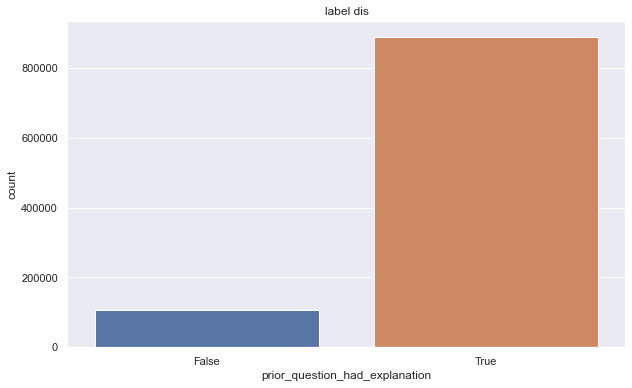

In [51]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_had_explanation')
plt.title('label dis')

### content_id

Text(0.5, 1.0, 'content dis')

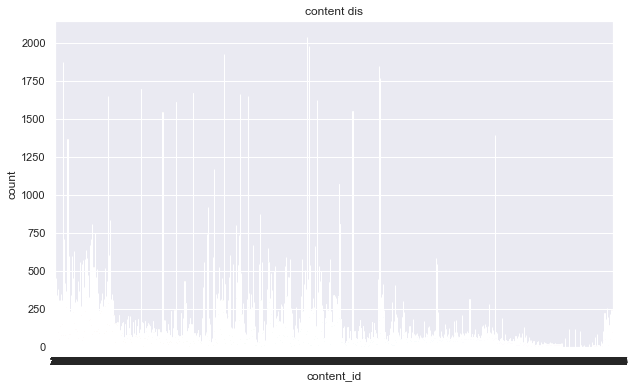

In [12]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='content_id')
plt.title('content dis')

In [22]:
train.groupby('content_id')['row_id'].count().sort_values()

content_id
12504       1
12945       1
12944       1
12940       1
12939       1
         ... 
7876     1847
175      1877
4120     1924
6173     1978
6116     2041
Name: row_id, Length: 13320, dtype: int64

In [38]:
a=train.groupby('content_id')['row_id'].count().sort_values()
len(a[a<=50])/len(a)

0.5168918918918919

<AxesSubplot:>

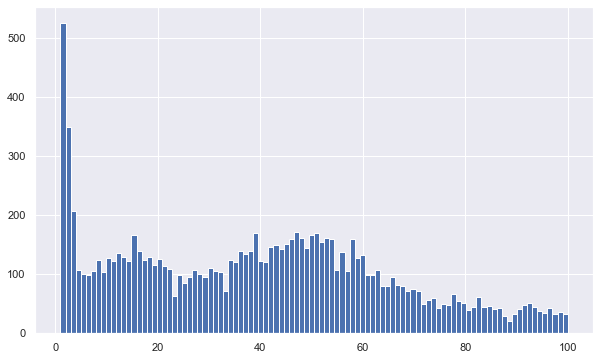

In [50]:
plt.figure(figsize=(10,6))
a[a<=100].hist(bins=100)

### user_id

In [32]:
train.groupby('user_id')['row_id'].count().sort_values()

user_id
19887248        1
1880240         1
15960740        2
2148001         2
1946295         3
            ...  
4421282      6962
9418512      7482
1283420      7569
18122922     7593
7171715     10826
Name: row_id, Length: 3824, dtype: int64

In [49]:
b=train.groupby('user_id')['row_id'].count().sort_values()
len(b[b==1])/len(b)

0.0005230125523012552

<AxesSubplot:>

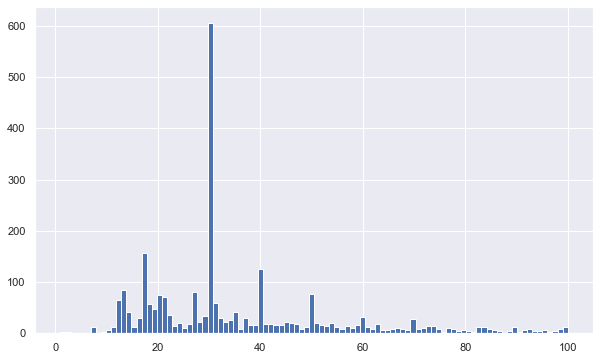

In [48]:
plt.figure(figsize=(10,6))
b[b<=100].hist(bins=100)

### task_container_id

In [39]:
train.groupby('task_container_id')['row_id'].count().sort_values()

task_container_id
7739       1
6324       1
6325       1
6326       1
6327       1
        ... 
6       6722
5       6732
4       6753
15      7806
14      7845
Name: row_id, Length: 7740, dtype: int64

In [45]:
c=train.groupby('task_container_id')['row_id'].count().sort_values()
len(c[c==1])/len(c)

0.26356589147286824

<AxesSubplot:>

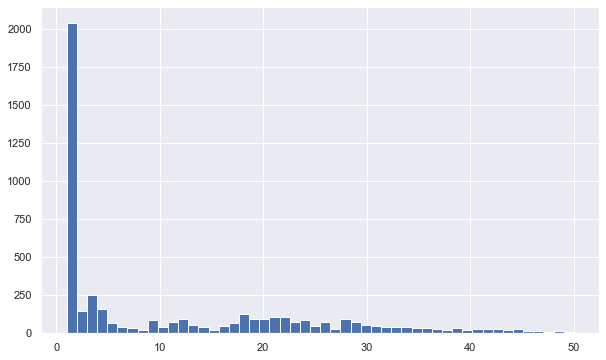

In [44]:
plt.figure(figsize=(10,6))
c[c<=50].hist(bins=50)

### prior_question_elapsed_time

Text(0.5, 1.0, 'content dis')

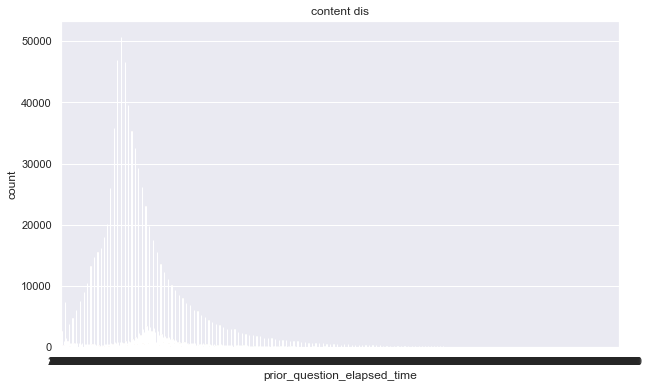

In [74]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_elapsed_time')
plt.title('content dis')

In [72]:
train.groupby('prior_question_elapsed_time')['row_id'].count().sort_values()

prior_question_elapsed_time
212750.0        1
119600.0        1
150800.0        1
151500.0        1
168800.0        1
            ...  
15000.0     35889
19000.0     39580
18000.0     46550
16000.0     46949
17000.0     50744
Name: row_id, Length: 1659, dtype: int64

In [70]:
train.groupby('prior_question_elapsed_time')[['row_id']].count().reset_index().sort_values(by=['prior_question_elapsed_time'])

,prior_question_elapsed_time,row_id
0,0.0,2701
1,200.0,3
2,250.0,12
3,333.0,369
4,400.0,5
...,...,...
1654,295000.0,4
1655,296000.0,7
1656,297000.0,1
1657,298000.0,2


In [97]:
e=train[train['prior_question_elapsed_time']<=17000.0][['row_id']].count()
e[0]/len(train)

0.341002